In [1]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier

In [3]:
df = pd.read_excel('NASA_data_set.xlsx')
df = df.drop(columns=["koi_teq_err1","koi_score", "koi_teq_err2","kepid","kepoi_name","kepler_name","dec","ra","koi_teq","koi_insol","koi_tce_delivname","koi_period_err1","koi_tce_plnt_num","koi_period_err2","koi_time0bk_err1","koi_time0bk_err2","koi_impact_err1","koi_impact_err2","koi_duration_err1","koi_duration_err2","koi_depth_err1","koi_depth_err2","koi_prad_err1","koi_prad_err2","koi_teq_err1","koi_teq_err2","koi_insol_err1","koi_insol_err2","koi_steff_err1","koi_steff_err2","koi_slogg_err1","koi_slogg_err2","koi_srad_err1","koi_srad_err2","koi_pdisposition","koi_fpflag_nt","koi_fpflag_ss","koi_fpflag_co","koi_fpflag_ec"])
df.head()

,koi_disposition,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,CONFIRMED,9.488036,170.538750,0.146,2.95750,615.8,2.26,35.8,5455.0,4.467,0.927,15.347
1,CONFIRMED,54.418383,162.513840,0.586,4.50700,874.8,2.83,25.8,5455.0,4.467,0.927,15.347
2,CANDIDATE,19.899140,175.850252,0.969,1.78220,10829.0,14.60,76.3,5853.0,4.544,0.868,15.436
3,FALSE POSITIVE,1.736952,170.307565,1.276,2.40641,8079.2,33.46,505.6,5805.0,4.564,0.791,15.597
4,CONFIRMED,2.525592,171.595550,0.701,1.65450,603.3,2.75,40.9,6031.0,4.438,1.046,15.509


In [4]:
candidates_df = df[df['koi_disposition'] == 'CANDIDATE'].copy()

# Create the training dataset using only labeled data
train_df = df[df['koi_disposition'] != 'CANDIDATE'].copy()

print(f"Training data size: {len(train_df)}")
print(f"Candidate data size for final prediction: {len(candidates_df)}")

Training data size: 7585
Candidate data size for final prediction: 1979


In [9]:
train_df['koi_disposition'] = train_df['koi_disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

In [10]:
features_to_drop = [
    'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
    'koi_pdisposition'
]

In [12]:
# safer dropping
drop_cols = [col for col in features_to_drop if col in train_df.columns]

y = train_df['koi_disposition']
X = train_df.drop(columns=drop_cols)

In [13]:
X_candidates = candidates_df.drop(columns=drop_cols)

In [14]:
for col in X.columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        # Use the SAME median from the training data to fill the candidate data
        X_candidates[col].fillna(median_val, inplace=True)

print("Preprocessing complete. No missing values remain.")

Preprocessing complete. No missing values remain.


/tmp/ipython-input-1991848269.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(median_val, inplace=True)
/tmp/ipython-input-1991848269.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25, # 25% for validation
    random_state=42,
    stratify=y
)

In [16]:
model = CatBoostClassifier(random_state=42, verbose=0, iterations=500)

# Train the model on the training data
model.fit(X_train, y_train)


--- Evaluating Model Performance on Validation Set ---
Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.95      0.94      0.95      1210
     CONFIRMED       0.90      0.92      0.91       687

      accuracy                           0.93      1897
     macro avg       0.93      0.93      0.93      1897
  weighted avg       0.93      0.93      0.93      1897

Confusion Matrix:


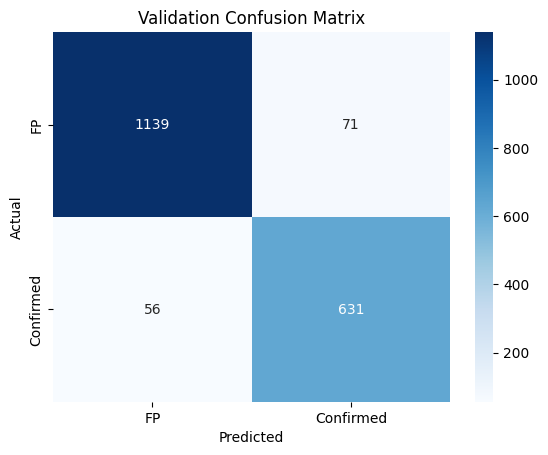

In [17]:
print("\n--- Evaluating Model Performance on Validation Set ---")

# Make predictions on the unseen validation data
y_pred = model.predict(X_val)

# Print the classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['FALSE POSITIVE', 'CONFIRMED']))

# Display a more visual confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FP', 'Confirmed'], yticklabels=['FP', 'Confirmed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

In [18]:
candidate_predictions = model.predict(X_candidates)

# Get the probability scores (how confident the model is)
candidate_probabilities = model.predict_proba(X_candidates)[:, 1] # Probability of being 'CONFIRMED'

In [20]:
results_df = candidates_df.copy()
results_df['predicted_disposition'] = ['CONFIRMED' if pred == 1 else 'FALSE POSITIVE' for pred in candidate_predictions]
results_df['probability_confirmed'] = candidate_probabilities

print("Final Predictions on Candidate Data:")
# Display the first 10 candidates and their new classifications
print(results_df.head(10))

Final Predictions on Candidate Data:
    koi_disposition  koi_period  koi_time0bk  koi_impact  koi_duration  \
2         CANDIDATE   19.899140   175.850252      0.9690        1.7822   
58        CANDIDATE   40.419504   173.564690      0.9110        3.3620   
62        CANDIDATE    7.240661   137.755450      1.1980        0.5580   
63        CANDIDATE    3.435916   132.662400      0.6240        3.1330   
84        CANDIDATE   10.181584   177.141891      0.9200        3.5089   
92        CANDIDATE   19.620347   181.881819      0.4580        2.0038   
112       CANDIDATE   34.843986   172.633252      0.9340        2.9315   
118       CANDIDATE    4.640900   173.646380      1.2800       35.5120   
123       CANDIDATE    1.028437   170.228582      1.5734        1.8606   
166       CANDIDATE  235.998640   208.399822      0.7780        8.2284   

     koi_depth  koi_prad  koi_model_snr  koi_steff  koi_slogg  koi_srad  \
2      10829.0     14.60           76.3     5853.0      4.544     0.868  

In [21]:
results_df.to_csv('candidate_planet_predictions.csv', index=False)

In [22]:
# Save the model
model.save_model("catboost_model.cbm")

In [23]:
# Load it later
from catboost import CatBoostClassifier
loaded_model = CatBoostClassifier()
loaded_model.load_model("catboost_model.cbm")